In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Environment check
import sys, torch, transformers, datasets, sklearn
print("which python:", sys.executable)
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("CUDA available:", torch.cuda.is_available())


which python: /Users/hd/Desktop/EMOTION-PRED/.venv/bin/python
PyTorch version: 2.4.1
Transformers version: 4.44.2
Datasets version: 4.4.1
CUDA available: False


In [3]:
# Import core libraries

# Hugging Face
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig
)
from datasets import load_dataset
from huggingface_hub import list_datasets

# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation and metrics
from sklearn.metrics import classification_report, confusion_matrix

# System utilities
import os
import re
import json
import torch
import warnings

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification



In [4]:

# Step -- 2 Search all datasets mentioning "emotion" (limit to 50)
datasets_list = list_datasets(search="emotion", limit=50)

records = []
for ds in datasets_list:
    # Safely get attributes (handle None cases)
    card = ds.cardData or {}
    desc = card.get("description") or ""
    tasks = card.get("task_categories") or []
    
    records.append({
        "id": ds.id,
        "downloads": getattr(ds, "downloads", None),
        "likes": getattr(ds, "likes", None),
        "task_categories": tasks,
        "description": desc[:120]  # first 120 chars for readability
    })

df = pd.DataFrame(records)
pd.set_option("display.max_rows", None)
display(df)


,id,downloads,likes,task_categories,description
0,mteb/emotion,9535,17,[],
1,google-research-datasets/go_emotions,6604,248,[],
2,dair-ai/emotion,23917,425,[],
3,tukey/human_face_emotions_roboflow,32,8,[],
4,Johnson8187/Chinese_Multi-Emotion_Dialogue_Dat...,210,17,[],
5,UniDataPro/speech-emotion-recognition,25,2,[],
6,Mansooreh/sharif-emotional-speech-dataset,11,1,[],
7,Pyjay/emotion_nl,10,0,[],
8,SetFit/emotion,333,29,[],
9,SetFit/go_emotions,143,9,[],


In [5]:
# Step 3 — Load pre-annotated emotion dataset
dataset = load_dataset("go_emotions")
dataset_name = "go_emotions"

# Check available splits
print(dataset)

# View label names
label_names = dataset["train"].features["labels"].feature.names
print("Labels:", label_names)

# Quick preview
dataset["train"][0]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej'}

In [6]:
# Step 4 — Prepare a manageable test subset
sample_size = 1000  # You can adjust later
texts = dataset["test"]["text"][:sample_size]
true_labels = dataset["test"]["labels"][:sample_size]

print("Sample text example:", texts[0])
print("True label(s):", [label_names[i] for i in true_labels[0]])



Sample text example: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
True label(s): ['sadness']


In [7]:
# Step 5 — Define models to evaluate
MODEL_NAMES = [
    "j-hartmann/emotion-english-distilroberta-base",
    "j-hartmann/emotion-english-roberta-large",
    "nateraw/bert-base-uncased-emotion",
    "joeddav/distilbert-base-uncased-go-emotions-student",
    "cardiffnlp/twitter-roberta-base-emotion",
    "mrm8488/t5-base-finetuned-emotion",
    "SamLowe/roberta-base-go_emotions",
]


In [8]:

# Folder to store built-in emotion label sets
BUILTIN_DIR = "built_in_emotions"
os.makedirs(BUILTIN_DIR, exist_ok=True)

for model_name in MODEL_NAMES:
    try:
        print(f"Inspecting {model_name} ...")

        # Load config (no weights needed)
        config = AutoConfig.from_pretrained(model_name)
        id2label = getattr(config, "id2label", None)
        label2id = getattr(config, "label2id", None)

        # Extract label list (some configs only have label2id)
        if id2label:
            labels = list(id2label.values())
        elif label2id:
            labels = list(label2id.keys())
        else:
            labels = []

        # Build metadata
        meta = {
            "model_name": model_name,
            "num_labels": len(labels),
            "labels": labels
        }

        # Safe file name
        safe_name = re.sub(r"[^a-zA-Z0-9]", "_", model_name)
        json_path = f"/Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/{safe_name}.json"

        # Write JSON
        with open(json_path, "w") as f:
            json.dump(meta, f, indent=4)

        print(f"Saved → {json_path}")

    except Exception as e:
        print(f"Failed for {model_name}: {e}")

print("All built-in emotion label sets exported.")


Inspecting j-hartmann/emotion-english-distilroberta-base ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/j_hartmann_emotion_english_distilroberta_base.json
Inspecting j-hartmann/emotion-english-roberta-large ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/j_hartmann_emotion_english_roberta_large.json
Inspecting nateraw/bert-base-uncased-emotion ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/nateraw_bert_base_uncased_emotion.json
Inspecting joeddav/distilbert-base-uncased-go-emotions-student ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/joeddav_distilbert_base_uncased_go_emotions_student.json
Inspecting cardiffnlp/twitter-roberta-base-emotion ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/cardiffnlp_twitter_roberta_base_emotion.json
Inspecting mrm8488/t5-base-finetuned-emotion ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/mrm8488_t5_base_finetuned_emotion.json
Inspecting SamLowe/r

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

def evaluate_model(model_name, texts, true_labels, label_names, sample_limit=200):
    """
    Universal evaluation for emotion models.
    Works with:
        - single-label or multi-label datasets
        - T5 / text-generation models
        - standard text-classification models
        - custom label spaces (e.g. Twitter 4-class)
    Returns:
        (classification_report_df, confusion_matrix_array)
    """
    print(f"\n🔹 Evaluating model: {model_name}")
    model_name_low = model_name.lower()

    # === 1. Select appropriate pipeline ===
    if "t5" in model_name_low:
        clf = pipeline("text2text-generation", model=model_name, tokenizer=model_name)

        def classify(text):
            out = clf(f"classify emotion: {text}")[0]["generated_text"]
            return out.strip().lower()

    elif "go_emotions" in model_name_low:
        clf = pipeline("text-classification", model=model_name, tokenizer=model_name, return_all_scores=True)

        def classify(text):
            results = clf(text)[0]
            best = sorted(results, key=lambda x: x["score"], reverse=True)[0]
            return best["label"].lower()

    elif "cardiffnlp" in model_name_low:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        labels = ['anger', 'joy', 'optimism', 'sadness']

        def classify(text):
            inputs = tokenizer(text, return_tensors="pt", truncation=True)
            with torch.no_grad():
                logits = model(**inputs).logits
            pred = torch.softmax(logits, dim=1)
            return labels[torch.argmax(pred).item()].lower()

    else:
        clf = pipeline("text-classification", model=model_name, tokenizer=model_name, top_k=1)

        def classify(text):
            result = clf(text)[0]
            if isinstance(result, list):
                result = result[0]
            return result["label"].lower()

    # === 2. Run predictions ===
    preds = []
    for t in texts[:sample_limit]:
        try:
            preds.append(classify(t))
        except Exception:
            preds.append("unknown")

    # === 3. Normalize true labels ===
    if isinstance(true_labels[0], list):     # multi-label → flatten
        true_labels = [lbl[0] if len(lbl) > 0 else -1 for lbl in true_labels]
        print("⚙ Flattened multi-label dataset → single label per sample.")

    # === 4. Convert string preds → indices ===
    pred_indices = [label_names.index(p) if p in label_names else -1 for p in preds]

    valid_idx = [i for i, x in enumerate(pred_indices) if x != -1 and true_labels[i] != -1]
    y_true = [true_labels[i] for i in valid_idx]
    y_pred = [pred_indices[i] for i in valid_idx]

    if len(y_true) == 0 or len(set(y_true)) < 2:
        print("⚠ Not enough valid samples for metrics.")
        return pd.DataFrame(), np.zeros((len(label_names), len(label_names)))

    # === 5. Compute metrics (adaptive labels) ===
    unique_labels_used = sorted(set(y_true + y_pred))
    label_names_used = [label_names[i] for i in unique_labels_used]

    report = classification_report(
        y_true, y_pred,
        labels=unique_labels_used,
        target_names=label_names_used,
        output_dict=True,
        zero_division=0
    )
    df_report = pd.DataFrame(report).transpose()
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_used)

    # === 6. Diagnostics ===
    predicted_classes = set([label_names[i] for i in pred_indices if i != -1])
    missing = set(label_names) - predicted_classes
    if missing:
        print(f"⚠ Model did not predict these classes: {', '.join(sorted(missing))}")
    else:
        print("✅ Model predicted all emotion classes.")

    macro_f1 = report["macro avg"]["f1-score"]
    print(f"📊 Macro-F1: {macro_f1:.4f} | Samples evaluated: {len(y_true)}")

    return df_report, cm



🔹 Evaluating model: j-hartmann/emotion-english-distilroberta-base


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, embarrassment, excitement, gratitude, grief, love, nervousness, optimism, pride, realization, relief, remorse
📊 Macro-F1: 0.0955 | Samples evaluated: 200


,precision,recall,f1-score,support
admiration,0.000000,0.000000,0.000000,13.00
amusement,0.000000,0.000000,0.000000,10.00
anger,0.285714,0.666667,0.400000,6.00
annoyance,0.000000,0.000000,0.000000,12.00
approval,0.000000,0.000000,0.000000,7.00
caring,0.000000,0.000000,0.000000,7.00
confusion,0.000000,0.000000,0.000000,6.00
curiosity,0.000000,0.000000,0.000000,7.00
desire,0.000000,0.000000,0.000000,3.00
disappointment,0.000000,0.000000,0.000000,3.00


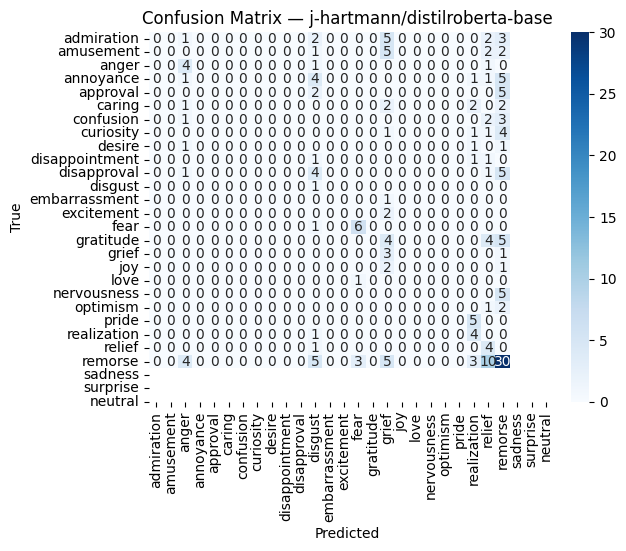

In [10]:
# Step 7 — Test one model first
report_df, cm = evaluate_model(
    "j-hartmann/emotion-english-distilroberta-base",
    texts, true_labels, label_names, sample_limit=200
)

display(report_df)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — j-hartmann/distilroberta-base")
plt.show()


In [11]:
# Step 8 — Evaluate all models
results = {}

for model in MODEL_NAMES:
    try:
        df_report, cm = evaluate_model(model, texts, true_labels, label_names, sample_limit=200)
        results[model] = df_report
    except Exception as e:
        print(f" {model} failed: {e}")



🔹 Evaluating model: j-hartmann/emotion-english-distilroberta-base


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, embarrassment, excitement, gratitude, grief, love, nervousness, optimism, pride, realization, relief, remorse
📊 Macro-F1: 0.0955 | Samples evaluated: 200

🔹 Evaluating model: j-hartmann/emotion-english-roberta-large


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, embarrassment, excitement, gratitude, grief, love, nervousness, optimism, pride, realization, relief, remorse
📊 Macro-F1: 0.0919 | Samples evaluated: 200

🔹 Evaluating model: nateraw/bert-base-uncased-emotion


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, gratitude, grief, nervousness, neutral, optimism, pride, realization, relief, remorse
📊 Macro-F1: 0.0620 | Samples evaluated: 200

🔹 Evaluating model: joeddav/distilbert-base-uncased-go-emotions-student


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: grief
📊 Macro-F1: 0.2309 | Samples evaluated: 200

🔹 Evaluating model: cardiffnlp/twitter-roberta-base-emotion


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, love, nervousness, neutral, pride, realization, relief, remorse, surprise
📊 Macro-F1: 0.0207 | Samples evaluated: 200

🔹 Evaluating model: mrm8488/t5-base-finetuned-emotion


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: admiration, amusement, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, gratitude, grief, nervousness, neutral, optimism, pride, realization, relief, remorse
📊 Macro-F1: 0.0477 | Samples evaluated: 199

🔹 Evaluating model: SamLowe/roberta-base-go_emotions


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


⚙ Flattened multi-label dataset → single label per sample.
⚠ Model did not predict these classes: excitement, grief, pride, relief
📊 Macro-F1: 0.4915 | Samples evaluated: 200


In [12]:
# Step 9 — Compare macro-F1 across models
summary = pd.DataFrame({
    model: results[model].loc["macro avg", "f1-score"]
    for model in results.keys()
}, index=["Macro F1"]).T

summary.sort_values("Macro F1", ascending=False)


,Macro F1
SamLowe/roberta-base-go_emotions,0.491455
joeddav/distilbert-base-uncased-go-emotions-student,0.230873
j-hartmann/emotion-english-distilroberta-base,0.095460
j-hartmann/emotion-english-roberta-large,0.091858
nateraw/bert-base-uncased-emotion,0.062045
mrm8488/t5-base-finetuned-emotion,0.047692
cardiffnlp/twitter-roberta-base-emotion,0.020723


In [13]:
# Step 10 — Save metrics to disk in a dedicated results folder
import os

RESULTS_DIR = f"/Users/hd/Desktop/EMOTION-PRED/src/results/results_{dataset_name}"
os.makedirs(RESULTS_DIR, exist_ok=True)  # Create if not exists

for model, df in results.items():
    safe_name = model.replace("/", "_")
    output_path = os.path.join(RESULTS_DIR, f"results_{safe_name}.csv")
    df.to_csv(output_path, index=True)
    print(f"Saved metrics → {output_path}")

print("\n All model reports saved to:", os.path.abspath(RESULTS_DIR))


Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_j-hartmann_emotion-english-distilroberta-base.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_j-hartmann_emotion-english-roberta-large.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_nateraw_bert-base-uncased-emotion.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_joeddav_distilbert-base-uncased-go-emotions-student.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_cardiffnlp_twitter-roberta-base-emotion.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_mrm8488_t5-base-finetuned-emotion.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_go_emotions/results_SamLowe_roberta-base-go_emotions.csv

 All model reports saved to: /Users/hd/Desktop/EMOTION-PRED/src/results/results_go